# Introduction

In this notebook, I will explore sentiment classification on Twitter data, which contains tweets labeled with either positive or negative sentiment. The base model I utilized is a pre-trained SentenceTransformer model called all-MiniLM-L6-v2. This baseline model accurately classifies the sentiment of tweets within the dataset 77% of the time.

The goal of this analysis is to enhance the model's ability to accurately classify the sentiment of tweets by fine-tuning the model's embeddings to improve its capacity to distinguish between positive and negative sentiments.

# Installing and Importing Necessary Packages

In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install nltk
!pip install sentence-transformers
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install datasets
!pip install tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
#Importing necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from datasets import Dataset

# Loading Data


First, I loaded the dataset from Hugging Face's dataset repository and then converted it into two DataFrames: one representing the training dataset and the other representing the testing dataset.

In [ ]:
# Loading data set and converting to dataframe
dataset = load_dataset('carblacac/twitter-sentiment-analysis', trust_remote_code=True)

# Converting each split to Pandas DataFrame
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

# Viewing the train data
print("Train set:")
print(df_train.head())
df_train.dtypes

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/149985 [00:00<?, ? examples/s]

Map:   0%|          | 0/61998 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/120 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/62 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/119988 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29997 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/61998 [00:00<?, ? examples/s]

Train set:
                                                text  feeling
0  @fa6ami86 so happy that salman won.  btw the 1...        0
1  @phantompoptart .......oops.... I guess I'm ki...        0
2  @bradleyjp decidedly undecided. Depends on the...        1
3  @Mountgrace lol i know! its so frustrating isn...        1
4  @kathystover Didn't go much of any where - Lif...        1


,0
text,object
feeling,int64


Next, I examined the token length of the text within the dataset to identify any entries that might require special handling, such as those exceeding the acceptable token length for our base model (sentence-transformers/all-MiniLM-L6-v2).

In [ ]:
# Preprocessing the data through tokenization

# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Function to calculate token length
def token_length(text):
    return len(tokenizer.encode(text, add_special_tokens=True))

# Calculating token length
df_train['token_length'] = df_train['text'].apply(token_length)

# Summary statistics for token length
token_summary = df_train['token_length'].describe()
print("Token Length Summary:")
print(token_summary)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Token Length Summary:
count    119988.000000
mean         23.102794
std          10.811415
min           3.000000
25%          15.000000
50%          22.000000
75%          31.000000
max         304.000000
Name: token_length, dtype: float64


# Embedding Text Data

Next, I converted the text data into embeddings using the all-MiniLM-L6-v2 model, preparing the data for classifying the tweets as either positive or negative.

In [ ]:
# Checking if GPU is available and setting the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, using CPU instead')

# Loading the model and putting it on the selected device
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model.to(device)

# Function to embed text using the preloaded model
def embed_text(text):
    embedding = model.encode([text])
    return embedding[0]

# Embedding text in batches
def batch_embed_text(texts, batch_size=32):
    embedded_texts = []
    # Wrap the range with tqdm for a progress bar
    for start in tqdm(range(0, len(texts), batch_size), desc="Embedding Texts", unit="batch"):
        batch = texts[start:start + batch_size]
        embedded_texts.extend(model.encode(batch, show_progress_bar=False))
    return embedded_texts

# Applying the embedding function
df_train['embedding'] = batch_embed_text(df_train['text'].tolist())

# Displaying the updated DataFrame
df_train.head()

GPU is available


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding Texts: 100%|██████████| 3750/3750 [00:37<00:00, 100.89batch/s]


,text,feeling,token_length,embedding
0,@fa6ami86 so happy that salman won. btw the 1...,0,25,"[-0.0115657495, 0.04047983, 0.005100516, -0.06..."
1,@phantompoptart .......oops.... I guess I'm ki...,0,41,"[-0.07101006, -0.061564263, 0.100741185, -0.03..."
2,@bradleyjp decidedly undecided. Depends on the...,1,34,"[0.043907568, -0.07721545, 0.06695625, -0.0510..."
3,@Mountgrace lol i know! its so frustrating isn...,1,19,"[-0.0011510896, -0.048209142, 0.052455198, -0...."
4,@kathystover Didn't go much of any where - Lif...,1,21,"[-0.05285654, -0.019670531, 0.0757241, 0.00044..."


# Applying Logistic Regression to Determine Base Model Performance

After converting the text into embeddings, I applied logistic regression on the generated embeddings to evaluate the baseline performance of our model in classifying tweets as either positive or negative in sentiment.

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     11954
           1       0.77      0.78      0.77     12044

    accuracy                           0.77     23998
   macro avg       0.77      0.77      0.77     23998
weighted avg       0.77      0.77      0.77     23998



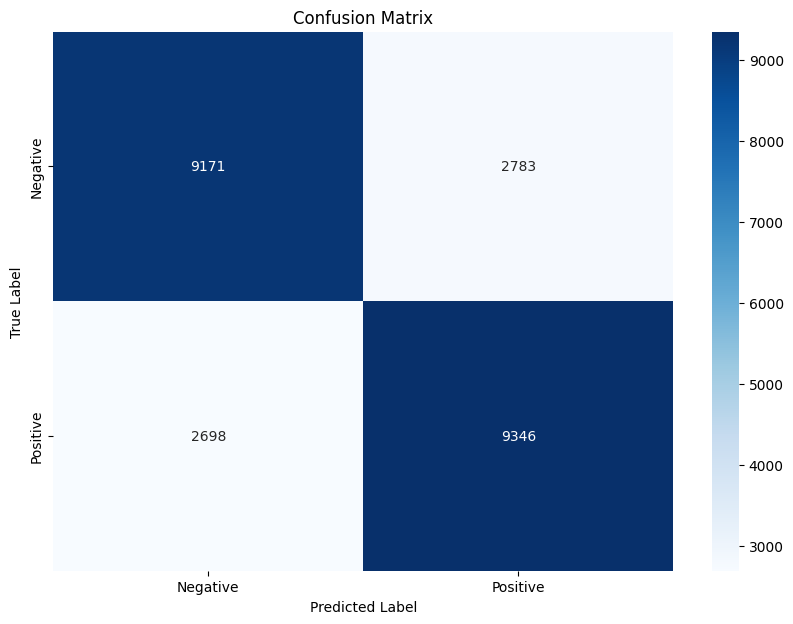

In [ ]:
# Defining X and y variables
X = df_train['embedding'].tolist()
y = df_train['feeling']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))

#Viewing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Interpretation of Model Performance

The accuracy of 77% indicates that the model correctly predicts the sentiment for 77% of the test instances.

The similar values for precision, recall, and F1-score suggest that the model is equally effective at correctly identifying both positive and negative sentiments, as well as at minimizing false positives and false negatives.

However, the confusion matrix reveals a notable number of misclassifications, particularly in the areas of false positives and false negatives.

# Preparing Data for Finetuning of Base Model

Next, I reformatted the data into the necessary structure required to apply loss functions, enabling us to train the model and improve its performance.

In [ ]:
# Renaming the columns to match the expected structure of loss functions
modified_df = df_train.rename(columns={"text": "sentence", "feeling": "label"})
modified_df = modified_df.drop(columns=['token_length', 'embedding'])
modified_df_x = modified_df.sample(n=25000)

# Converting the DataFrame to a Dataset
train_dataset = Dataset.from_pandas(modified_df_x)
train_dataset = train_dataset.remove_columns(["__index_level_0__"])
train_dataset

Dataset({
    features: ['sentence', 'label'],
    num_rows: 25000
})

# Finetuning Base Model

Next, I fine-tuned our base model using different loss functions to improve its performance.

The loss functions I utilized included BatchAllTripletLoss, BatchHardSoftMarginTripletLoss, BatchHardTripletLoss, and BatchSemiHardTripletLoss. These functions are designed to fine-tune embedding models on training data for classification tasks.

For each loss function, I followed these steps:

1. Trained and saved the base model using the selected loss function.
2. Applied the fine-tuned model to the test data, creating updated embeddings.
3. Trained a logistic regression model on the fine-tuned embeddings to evaluate how well these embeddings capture sentiment information in the text data and correctly classify the tweets as positive or negative.

#Training Model Through BatchAllTripletLoss

1.) Training the base model with BatchAllTripletLoss and saving the fine-tuned model.

In [ ]:
# Training base model
model = SentenceTransformer("all-MiniLM-L6-v2")
loss = losses.BatchAllTripletLoss(model)

trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_dataset,
    loss=loss,
)
trainer.train()

# Saving the fine-tuned model
model.save("BatchAllTripletLoss_fine_tuned_all-MiniLM-L6-v2")

Step,Training Loss
500,4.568100
1000,4.431100
1500,4.402800
2000,4.447000
2500,4.353500
3000,4.332800
3500,4.249400
4000,4.301500
4500,4.232900
5000,4.106100


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

2.) Applying the fine-tuned model to the test data to update the embeddings.



In [ ]:
# Checking if GPU is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, using CPU instead')

# Loading the model and putting it on the selected device
model = SentenceTransformer('BatchAllTripletLoss_fine_tuned_all-MiniLM-L6-v2')
model.to(device)

# Embedding text in batches
def batch_embed_text(texts, batch_size=15000):
    embedded_texts = []
    # Wrap the range with tqdm for a progress bar
    for start in tqdm(range(0, len(texts), batch_size), desc="Embedding Texts", unit="batch"):
        batch = texts[start:start + batch_size]
        embedded_texts.extend(model.encode(batch, show_progress_bar=False, device=device))
    return embedded_texts

# Applying the embedding function
df_test['embedding'] = batch_embed_text(df_test['text'].tolist())

GPU is available


Embedding Texts: 100%|██████████| 5/5 [00:14<00:00,  2.98s/batch]


3.) Training the logistic regression model on the fine-tuned embeddings to assess how effectively they capture sentiment information in the text data and correctly classify the tweets as positive or negative.

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      6328
           1       0.82      0.79      0.80      6072

    accuracy                           0.81     12400
   macro avg       0.81      0.81      0.81     12400
weighted avg       0.81      0.81      0.81     12400



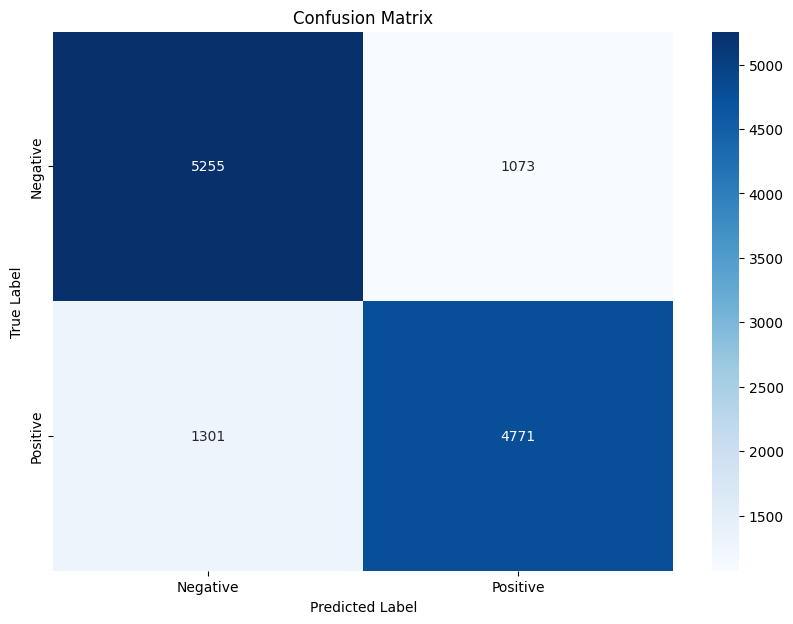

In [ ]:
# Renaming the 'feeling' column to 'label'
df_test = df_test.rename(columns={'feeling': 'label'})

#Defining X and y variables
X = df_test['embedding'].tolist()
y = df_test['label']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))

#Viewing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#BatchAllTripletLoss Performance


The model correctly classified 81% of all instances in the test set. The confusion matrix indicates that the model is fairly balanced in predicting both positive and negative sentiments, with a slightly better performance in accurately identifying negative sentiments.

# Training Model Through BatchHardSoftMarginTripletLoss

1.) Training the base model with BatchAllTripletLoss and saving the fine-tuned model.

In [ ]:
# Training base model
model = SentenceTransformer("all-MiniLM-L6-v2")
loss = losses.BatchHardSoftMarginTripletLoss(model)

trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_dataset,
    loss=loss,
)
trainer.train()

# Saving the fine-tuned model
model.save("BatchHardSoftMarginTripletLoss_fine_tuned_all-MiniLM-L6-v2")

Step,Training Loss
500,0.724600
1000,0.702700
1500,0.697400
2000,0.696900
2500,0.696800
3000,0.696200
3500,0.696100
4000,0.696100
4500,0.696000
5000,0.695600


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

2.) Applying the fine-tuned model to the test data and updating the embeddings.

In [ ]:
# Accessing test dataset
df_test = pd.DataFrame(dataset['test'])

# Checking if GPU is available and setting the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, using CPU instead')

# Loading the model and putting it on the selected device
model = SentenceTransformer('BatchHardSoftMarginTripletLoss_fine_tuned_all-MiniLM-L6-v2')
model.to(device)

# Embedding text in batches
def batch_embed_text(texts, batch_size=15000):
    embedded_texts = []
    # Wrap the range with tqdm for a progress bar
    for start in tqdm(range(0, len(texts), batch_size), desc="Embedding Texts", unit="batch"):
        batch = texts[start:start + batch_size]
        embedded_texts.extend(model.encode(batch, show_progress_bar=False, device=device))
    return embedded_texts

# Applying the embedding function
df_test['embedding'] = batch_embed_text(df_test['text'].tolist())

GPU is available


Embedding Texts: 100%|██████████| 5/5 [00:14<00:00,  2.93s/batch]


3.) Training the logistic regression model on the fine-tuned embeddings to evaluate how effectively they capture sentiment information in the text data and correctly classify the tweets as positive or negative.

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      6328
           1       0.82      0.81      0.82      6072

    accuracy                           0.82     12400
   macro avg       0.82      0.82      0.82     12400
weighted avg       0.82      0.82      0.82     12400



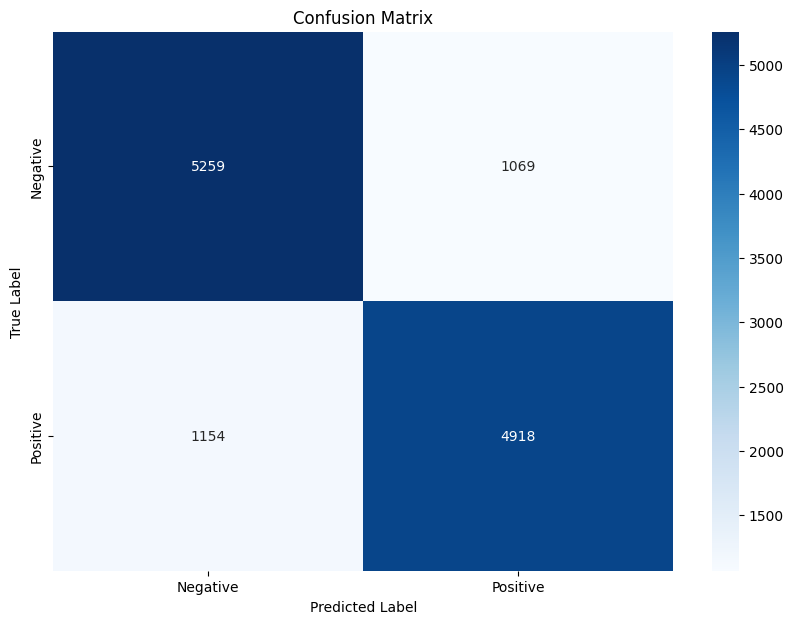

In [ ]:
# Renaming the 'feeling' column to 'label'
df_test = df_test.rename(columns={'feeling': 'label'})

# Defining X and y variables
X = df_test['embedding'].tolist()
y = df_test['label']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))

# Viewing confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#BatchHardSoftMarginTripletLoss Performance

The model correctly classified 82% of all instances in the test set. It performs consistently across both classes, with precision, recall, and F1-scores around 0.82 for both positive and negative sentiments. The confusion matrix indicates that the model predicts both sentiments relatively well, with a slightly better performance in accurately identifying negative sentiments.

# Training Model Through BatchHardTripletLoss

1.) Training the base model with BatchAllTripletLoss and saving the fine-tuned model.

In [ ]:
# Training Base Model
model = SentenceTransformer("all-MiniLM-L6-v2")
loss = losses.BatchHardTripletLoss(model)

trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_dataset,
    loss=loss,
)
trainer.train()

# Saving the fine-tuned model
model.save("BatchHardTripletLoss_fine_tuned_all-MiniLM-L6-v2")

Step,Training Loss
500,5.059500
1000,5.022700
1500,5.008300
2000,5.007200
2500,5.007100
3000,5.006100
3500,5.005900
4000,5.005600
4500,5.005400
5000,5.004500


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

2.) Applying the fine-tuned model to the test data and updating the embeddings.

In [ ]:
#Accessing test dataset
df_test = pd.DataFrame(dataset['test'])

# Checking if GPU is available and setting the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, using CPU instead')

# Loading the model and putting it on the selected device
model = SentenceTransformer('BatchHardTripletLoss_fine_tuned_all-MiniLM-L6-v2')
model.to(device)

# Embedding text in batches
def batch_embed_text(texts, batch_size=15000):
    embedded_texts = []
    # Wrap the range with tqdm for a progress bar
    for start in tqdm(range(0, len(texts), batch_size), desc="Embedding Texts", unit="batch"):
        batch = texts[start:start + batch_size]
        embedded_texts.extend(model.encode(batch, show_progress_bar=False, device=device))
    return embedded_texts

# Applying the embedding function
df_test['embedding'] = batch_embed_text(df_test['text'].tolist())

GPU is available


Embedding Texts: 100%|██████████| 5/5 [00:14<00:00,  2.92s/batch]


3.) Training the logistic regression model on the fine-tuned embeddings to evaluate how effectively they capture sentiment information in the text data and correctly classify the tweets as positive or negative.

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      6328
           1       0.82      0.81      0.82      6072

    accuracy                           0.82     12400
   macro avg       0.82      0.82      0.82     12400
weighted avg       0.82      0.82      0.82     12400



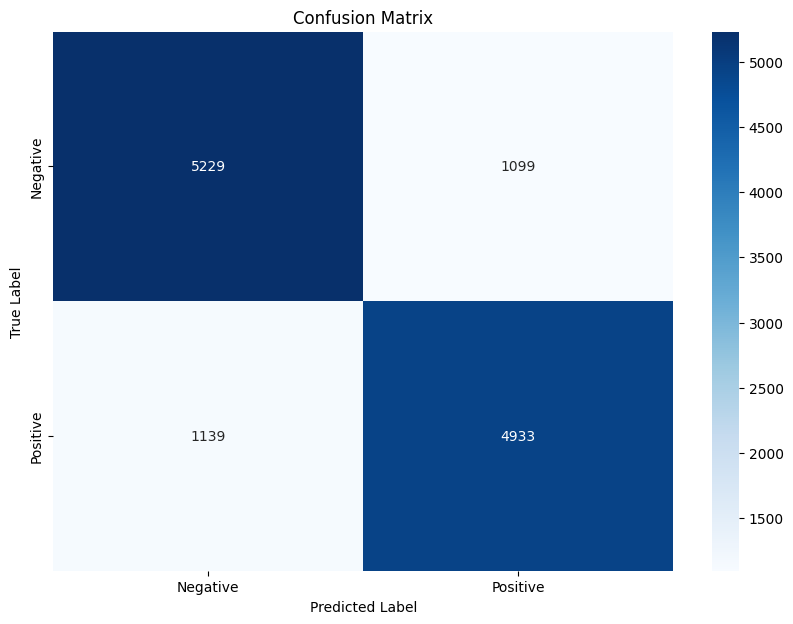

In [ ]:
# Renaming the 'feeling' column to 'label'
df_test = df_test.rename(columns={'feeling': 'label'})

# Defining X and y variables
X = df_test['embedding'].tolist()
y = df_test['label']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))

# Viewing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# BatchHardTripletLoss Performance


The model correctly classified 82% of all instances in the test set similar to BatchHardSoftMarginTripletLoss performance. The confusion matrix indicates that the model performs well in predicting both positive and negative sentiments, with slightly better accuracy in correctly identifying negative sentiments.




#Training Model Through BatchSemiHardTripletLoss

1.) Training the base model with BatchSemiHardTripletLoss and saving the fine-tuned model.

In [ ]:
# Training Base Model
model = SentenceTransformer("all-MiniLM-L6-v2")
loss = losses.BatchSemiHardTripletLoss(model)

trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_dataset,
    loss=loss,
)
trainer.train()

# Saving the fine-tuned model
model.save("BatchSemiHardTripletLoss_fine_tuned_all-MiniLM-L6-v2")

Step,Training Loss
500,4.692400
1000,4.481300
1500,4.427500
2000,4.442000
2500,4.455700
3000,4.399300
3500,4.375200
4000,4.356600
4500,4.351500
5000,4.284900


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

2.) Applying the fine-tuned model to the test data and updating the embeddings.

In [ ]:
# Accessing Test Data set
df_test = pd.DataFrame(dataset['test'])

# Checking if GPU is available and setting the device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, using CPU instead')

# Loading the model and putting it on the selected device
model = SentenceTransformer('BatchSemiHardTripletLoss_fine_tuned_all-MiniLM-L6-v2')
model.to(device)

# Embedding text in batches
def batch_embed_text(texts, batch_size=15000):
    embedded_texts = []
    # Wrap the range with tqdm for a progress bar
    for start in tqdm(range(0, len(texts), batch_size), desc="Embedding Texts", unit="batch"):
        batch = texts[start:start + batch_size]
        embedded_texts.extend(model.encode(batch, show_progress_bar=False, device=device))
    return embedded_texts

# Applying the embedding function
df_test['embedding'] = batch_embed_text(df_test['text'].tolist())

GPU is available


Embedding Texts: 100%|██████████| 5/5 [00:14<00:00,  2.97s/batch]


3.) Training the logistic regression model on the fine-tuned embeddings to assess how effectively they capture sentiment information in the text data and correctly classify the tweets as positive or negative.

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6328
           1       0.79      0.79      0.79      6072

    accuracy                           0.79     12400
   macro avg       0.79      0.79      0.79     12400
weighted avg       0.79      0.79      0.79     12400



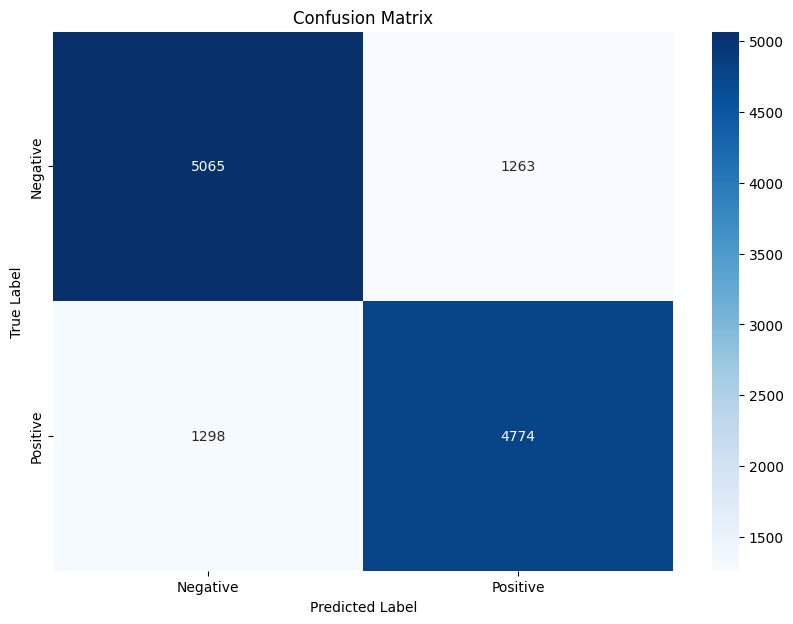

In [ ]:
# Renaming the 'feeling' column to 'label'
df_test = df_test.rename(columns={'feeling': 'label'})

# Defining X and y variables
X = df_test['embedding'].tolist()
y = df_test['label']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))

# Viewing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# BatchSemiHardTripletLoss Performance

The model correctly classified 79% of all instances in the test set, indicating slightly lower performance compared to the previous models.

# Conclusion

Through the application of different fine-tuning techniques, a significant improvement in the model's sentiment classification performance was achieved. The models fine-tuned with BatchHardTripletLoss and BatchHardSoftMarginTripletLoss showed the greatest improvement, with accuracy scores of 82%, enhancing the model's ability to correctly classify tweets as positive or negative.